### This notebook is for reproducing the paper results' subsection "Neurobiological relevance of a given brain partition in brain-related disorders by making use of neurogenetics data" and generate the panels of the figure 4. The objective of the notebook is to find out the optimal parcellation modules that are neurobiologically relevant in 32 different brain-related disorders.

In [1]:
import os
import abagen
import json
import nibabel as nib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from scipy.stats import zscore
from nilearn import plotting

from src.ni_functions import *
from src.tree_functions import *

First, it's needed to define the connectome size, it's possible to choose between the following number of nodes: 183, 391, 568, 729, 964, 1242, 1584, 1795, 2165. But, as we got in the previous notebook the best results for the 2165 nodes connectome, we will use this one.

In [4]:
project_path = "/workspaces/bha2"
CONN_SIZE = 2165

Loading the opitmal parcellation.

In [6]:
optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "iPA_" + str(CONN_SIZE),
        "processed",
        "optimal_parcellation.nii.gz",
    )
)
optimal_parcellation_data = optimal_parcellation.get_fdata()

The transcriptome matrix is calculated using the parcellation image as input. In order to not recalculate it, since it is very time-cost expensive, the code checks if it is already in the bha2/tmp folder. If it is not, the code will compute it.

In [ ]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv")):
    transcriptome = pd.read_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv"), index_col=0)
    print("transcriptome loaded from tmp folder")
    transcriptome = transcriptome.dropna(axis=1)
else:
    transcriptome = pd.DataFrame.transpose(abagen.get_expression_data(optimal_parcellation))
    transcriptome.to_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv"), index=True)
    transcriptome = transcriptome.dropna(axis=1)

In this section we compute the average expression per module of the genes related to each disorder. The results are displayed in a heatmap dividing the disorders in 7 groups according to their WHO classification and each module with a z-score greater than 2 or lower than -2 is marked with an \*. Disorders and genes related to them were extracted from (Zeighami et al., biorxiv, 2021). The lists of genes are uploaded to [Zenodo](https://zenodo.org/record/7709525) in the folder *individual_gda* and the *DiseaseWHOClass.csv* file is in the root of the folder. The only preprocessing step we performed was to substitute the underscores in the disease filenames by spaces. We locate the file and the folder in *data/raw*, and renamed the folder as *disease_genes*. The figure produced in this section is saved in the bha2/figures folder.

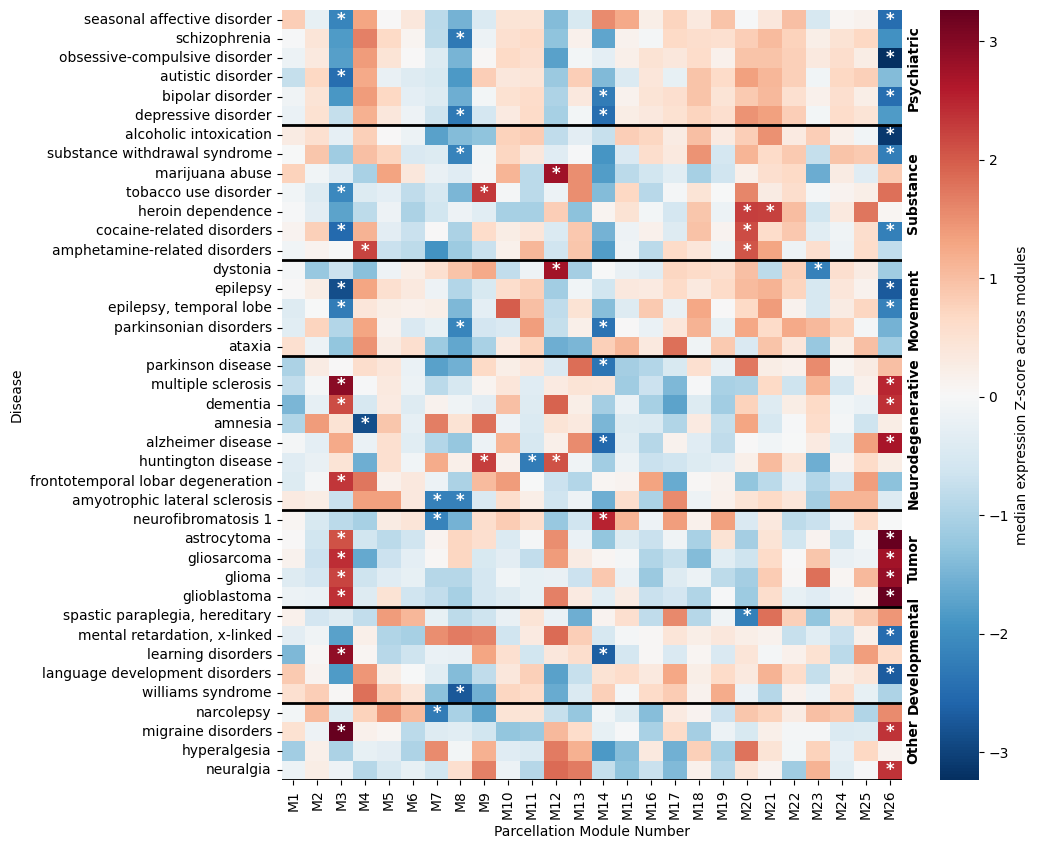

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]

diseaseWHO_class = pd.read_csv(os.path.join(project_path, "data", "DiseaseWHOClass.csv"), index_col=0).sort_values(by=['Class'])
disease_name = diseaseWHO_class.index.values
WHOclass_names = ['Psychiatric', 'Substance',  'Movement', 'Neurodegenerative', 'Tumor', 'Developmental', 'Other']
diseaseWHO_class["Class_name"] = diseaseWHO_class.Class.map({(i+1):WHOclass_names[i] for i in range(len(WHOclass_names))})


avg_exp_in_parcel = np.zeros((len(disease_name), transcriptome.shape[1]))
for idx_dis, dis in enumerate(disease_name):
    genes_in_dis = pd.read_csv(os.path.join(project_path, "data", "disease_genes", disease_name[idx_dis] + ".csv"), index_col=0)["x"].values
    transcriptome_in_dis = transcriptome.loc[transcriptome.index.isin(genes_in_dis), :]
    for m_parcel in range(transcriptome.shape[1]):
        avg_exp_in_parcel[idx_dis, m_parcel] = np.median(transcriptome_in_dis.iloc[:, m_parcel])
avg_exp_in_parcel_z = zscore(avg_exp_in_parcel, axis=1)
hmap = sns.heatmap(avg_exp_in_parcel_z, cmap="RdBu_r", cbar_kws={'label': 'median expression Z-score across modules'},
            yticklabels=disease_name, xticklabels=["M"+str(transcriptome.columns[m_number]) for m_number in range(transcriptome.shape[1])])

# annotate only the cells with values greater than 2 
for idx_dis, dis in enumerate(disease_name):
    for m_parcel in range(transcriptome.shape[1]):
        if (avg_exp_in_parcel_z[idx_dis, m_parcel] > 2) or (avg_exp_in_parcel_z[idx_dis, m_parcel] < -2):
            hmap.text(m_parcel+0.5, idx_dis+0.5, "*",
                      #f"{avg_exp_in_parcel_z[idx_dis, m_parcel]:.2f}", 
                      fontsize=12, color = "w", fontweight="bold", va="center", ha="center")

line_offset = 0
for who_classes in range(np.min(diseaseWHO_class["Class"]), np.max(diseaseWHO_class["Class"])+1):
    n_diseases_in_class = len(diseaseWHO_class[diseaseWHO_class["Class"]==who_classes])
    line_offset += n_diseases_in_class
    text_offset = line_offset - n_diseases_in_class/2
    hmap.axhline(line_offset, color="black", linewidth=2)
    # add the name of the class at the right of the line
    hmap.text(transcriptome.shape[1]+0.5, text_offset, diseaseWHO_class[diseaseWHO_class["Class"]==who_classes]["Class_name"].values[0], fontsize=10, fontweight="bold", rotation=90, va="center", ha="center")


plt.xlabel("Parcellation Module Number")
plt.ylabel("Disease")

plt.savefig(
    os.path.join(project_path, "data", "figures", "genetic_disorders.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)


In a similar way than in the previous section, we compute the average expression per module of the genes related to each WHO class, grouping all the genes of the disorders inside the class. Now the z-score values of each module per WHO class are displayed in a brain glass image. The figure is saved in the bha2/figures folder.

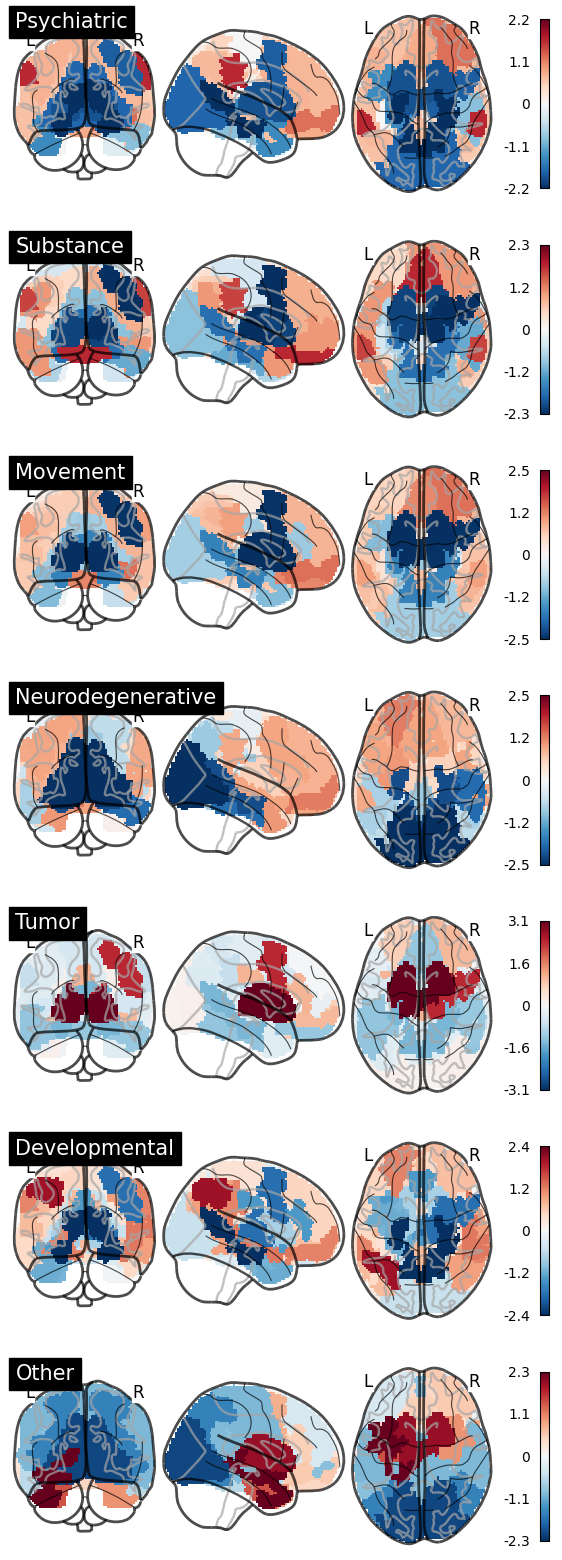

In [10]:
fig = plt.figure(figsize=(7, 20))

for idx, who_class in enumerate(range(np.min(diseaseWHO_class["Class"]), np.max(diseaseWHO_class["Class"])+1)):
    ax = fig.add_subplot(np.max(diseaseWHO_class["Class"]), 1, idx + 1)
    diseases_in_class = diseaseWHO_class[diseaseWHO_class["Class"]==who_class]
    genes_in_class = []
    for dis in diseases_in_class.index:
        genes_in_dis = pd.read_csv(os.path.join(project_path, "data", "disease_genes", dis + ".csv"), index_col=0)["x"].values
        genes_in_class = np.concatenate((genes_in_class, genes_in_dis))

    transcriptome_in_class = transcriptome.loc[transcriptome.index.isin(np.unique(genes_in_class)), :]
    class_avg_exp_in_parcel = []
    for m_parcel in range(transcriptome.shape[1]):
        class_avg_exp_in_parcel.append(np.median(transcriptome_in_class.iloc[:, m_parcel]))
    class_avg_exp_in_parcel_z = zscore(np.array(class_avg_exp_in_parcel))

    avg_exp_in_parcel_z_class_brain = np.zeros(optimal_parcellation_data.shape)
    for m_parcel in range(transcriptome.shape[1]):
        avg_exp_in_parcel_z_class_brain[optimal_parcellation_data==m_parcel+1] = class_avg_exp_in_parcel_z[m_parcel]
    avg_exp_in_parcel_z_class_brain_img = nib.Nifti1Image(avg_exp_in_parcel_z_class_brain, optimal_parcellation.affine)

    plotting.plot_glass_brain(
        avg_exp_in_parcel_z_class_brain_img,
        colorbar=True,
        title= WHOclass_names[idx],
        axes=ax,
        cmap="RdBu_r",
        plot_abs = False,
    )

    plt.savefig(
    os.path.join(project_path, "data", "figures", "gen_disorder_class_mean_across_genes.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
